In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# !unzip "/content/drive/MyDrive/archive.zip" -d "/content/"

In [7]:
import keras
import tensorflow as tf
import numpy as np
from keras.src.models import Sequential
from keras.src.layers import Conv2D, ReLU,MaxPooling2D, Dense, Dropout, Flatten, Input, LeakyReLU, GlobalAveragePooling2D, BatchNormalization
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Lambda, Normalization
from sklearn.utils.class_weight import compute_class_weight
from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.src.regularizers import L2
import cv2

train_dataset = keras.utils.image_dataset_from_directory(
    "/content/Axial CT Imaging Dataset for AI-Powered Kidney Stone Detection A Resource for Deep Learning Research/Axial CT Imaging Dataset for AI-Powered Kidney Stone Detection A Resource for Deep Learning Research/Kindy Stone Dataset/Augmented Dataset",
    labels="inferred",
    label_mode='binary',
    color_mode='rgb',
    batch_size=64
)

test_dataset = keras.utils.image_dataset_from_directory(
    "/content/Axial CT Imaging Dataset for AI-Powered Kidney Stone Detection A Resource for Deep Learning Research/Axial CT Imaging Dataset for AI-Powered Kidney Stone Detection A Resource for Deep Learning Research/Kindy Stone Dataset/Original Dataset",
    labels="inferred",
    label_mode='binary',
    color_mode='rgb',
    batch_size=64
)

Found 35457 files belonging to 2 classes.
Found 3364 files belonging to 2 classes.


In [8]:
data_augumentation =Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(factor=2/360),
    RandomZoom(0.02),
])

def histogram_equalization(image):
    def _equalize(img):
        img = img.astype(np.uint8)
        r, g, b = cv2.split(img)
        r = cv2.equalizeHist(r)
        g = cv2.equalizeHist(g)
        b = cv2.equalizeHist(b)
        return cv2.merge([r, g, b])

    equalized = tf.numpy_function(_equalize, [image], tf.uint8)
    equalized.set_shape([256, 256, 3])
    equalized = tf.cast(equalized,tf.float32)

    return equalized

def change_range(image):
    return  image / 255.

def preprocess_train(image,label):
    # image = histogram_equalization(image)
    image = change_range(image)
    # image = data_augumentation(image)
    return image,label

def preprocess_test(image,label):
    # image = histogram_equalization(image)
    image = change_range(image)
    return image,label


train_dataset = train_dataset.unbatch()
test_dataset = test_dataset.unbatch()

train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(6400).repeat().batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [9]:



# model = Sequential([

# Input(shape=(512, 512, 3)),

# Conv2D(64, (7, 7), strides=2, padding='same'),
# BatchNormalization(),
# LeakyReLU(negative_slope=0.01),
# MaxPooling2D((3, 3), strides=2),

# Conv2D(128, (3, 3), padding='same'),
# BatchNormalization(),
# LeakyReLU(negative_slope=0.01),
# Conv2D(128, (3, 3), padding='same'),
# BatchNormalization(),
# LeakyReLU(negative_slope=0.01),
# MaxPooling2D((2, 2)),
# Dropout(0.2),

# Conv2D(256, (3, 3), padding='same'),
# BatchNormalization(),
# LeakyReLU(negative_slope=0.01),
# Conv2D(256, (3, 3), padding='same'),
# LeakyReLU(negative_slope=0.01),
# BatchNormalization(),
# MaxPooling2D((2, 2)),
# Dropout(0.3),

# Conv2D(512, (3, 3), padding='same'),
# BatchNormalization(),
# LeakyReLU(negative_slope=0.01),
# Conv2D(512, (3, 3), padding='same'),
# BatchNormalization(),
# LeakyReLU(negative_slope=0.01),
# GlobalAveragePooling2D(),
# Dropout(0.5),

# Dense(1, activation='sigmoid',kernel_regularizer=L2(0.001))
# ])

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss="binary_crossentropy",
#     metrics=['accuracy', tf.keras.metrics.AUC()]
#     )

# model.summary()

In [10]:
from keras.src.layers import Add,Multiply,ZeroPadding2D,Dropout,ZeroPadding3D, BatchNormalization, LeakyReLU, ReLU, Conv2D, MaxPooling2D, UpSampling2D,  Conv3D, MaxPooling3D, UpSampling3D,concatenate, Input
from keras.src.models import Model

activations = {
    'relu': ReLU,
    'leaky_relu': LeakyReLU,
}

def IdentityBlock(x):

    return x

def Normalize(x, normalize):

    return BatchNormalization()(x) if normalize else x

def DropOut(x, drop_out):

    return Dropout(drop_out)(x) if 0.0 < drop_out < 1.0 else x

def SimpleResidualBlock(input_block, filter_size, kernel_size=(3,3), padding="same",
                 activation="relu", slope=0.0, pool_size=(2,2),
                 batch_normalization=False, drop_out=0.0,scale=True,pool=False,kernel_regularizer=None):

    if scale:
      input_block = Conv2D(filters=filter_size, kernel_size=kernel_size, padding=padding,kernel_regularizer=kernel_regularizer)(input_block)
      input_block = Normalize(input_block, batch_normalization)

    conv = Conv2D(filters=filter_size,kernel_size=kernel_size, padding=padding,kernel_regularizer=kernel_regularizer)(input_block)
    conv = Normalize(conv, batch_normalization)
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)

    conv = Conv2D(filters=filter_size, kernel_size=kernel_size, padding=padding,kernel_regularizer=kernel_regularizer)(conv)
    conv = Normalize(conv, batch_normalization)
    conv = Add()([conv, input_block])
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)

    if pool:
      conv = MaxPooling2D(pool_size=pool_size)(conv)

    conv = DropOut(conv, drop_out)



    return conv

def ResidualBlock(input_block, filter_size,filter_size_end, kernel_size=(1,1),kernel_size_center=(3,3),scale = False,pool=False, padding="same",
                 activation="relu", slope=0.0, pool_size=(2,2),
                 batch_normalization=False, drop_out=0.0,kernel_regularizer=None):

    if scale:
      input_block = Conv2D(filters=filter_size_end, kernel_size=kernel_size, padding=padding,kernel_regularizer=kernel_regularizer)(input_block)
      input_block = Normalize(input_block, batch_normalization)

    conv = Conv2D(filters=filter_size,kernel_size=kernel_size, padding=padding,kernel_regularizer=kernel_regularizer)(input_block)
    conv = Normalize(conv, batch_normalization)
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)

    conv = Conv2D(filters=filter_size, kernel_size=kernel_size_center, padding=padding,kernel_regularizer=kernel_regularizer)(conv)
    conv = Normalize(conv, batch_normalization)
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)

    conv = Conv2D(filters=filter_size_end, kernel_size=kernel_size, padding=padding,kernel_regularizer=kernel_regularizer)(conv)
    conv = Normalize(conv, batch_normalization)
    conv = Add()([conv, input_block])
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)



    if pool:
      conv = MaxPooling2D(pool_size=pool_size)(conv)

    conv = DropOut(conv, drop_out)



    return conv

def StartBlock(input_block, filter_size, kernel_size=(7,7), padding="same",
                 activation="relu", slope=0.0, pool_size=(2,2),strides=2,
                 batch_normalization=False, drop_out=0,kernel_regularizer=None):

    conv = Conv2D(filters=filter_size,kernel_size=kernel_size, padding=padding,strides = strides,kernel_regularizer=kernel_regularizer)(input_block)
    conv = Normalize(conv, batch_normalization)
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)
    pool = MaxPooling2D(pool_size=pool_size)(conv)
    pool = DropOut(pool, drop_out)

    return pool

def FlattenResidualBlock(input_block,drop_out=0.0):
    pool = GlobalAveragePooling2D()(input_block)
    pool = DropOut(pool, drop_out)

    return pool

In [11]:
from keras.src.models import Model

input = Input(shape=(256, 256, 3))
start = StartBlock(input, filter_size=64, kernel_size=(7, 7), strides=2,batch_normalization=True)

residual1 = SimpleResidualBlock(start, filter_size=64, kernel_size=(3, 3), padding="same",
                                batch_normalization=True)
residual2 = SimpleResidualBlock(residual1, filter_size=64, kernel_size=(3, 3), padding="same",
                                batch_normalization=True,drop_out=0.2)

residual3 = SimpleResidualBlock(residual2, filter_size=128, kernel_size=(3, 3), padding="same",scale=True,
                                batch_normalization=True)
residual4 = SimpleResidualBlock(residual3, filter_size=128, kernel_size=(3, 3), padding="same",
                                batch_normalization=True,drop_out=0.2)

residual5 = SimpleResidualBlock(residual4, filter_size=256, kernel_size=(3, 3), padding="same",scale=True,
                                batch_normalization=True)
residual6 = SimpleResidualBlock(residual5, filter_size=256, kernel_size=(3, 3), padding="same",
                                batch_normalization=True,drop_out=0.2)


residual5 = SimpleResidualBlock(residual4, filter_size=512, kernel_size=(3, 3), padding="same",scale=True,
                                batch_normalization=True)
residual6 = SimpleResidualBlock(residual5, filter_size=512, kernel_size=(3, 3), padding="same",
                                batch_normalization=True,drop_out=0.2)


flatten = FlattenResidualBlock(residual6,drop_out=0.5)
output = Dense(1, activation='sigmoid',kernel_regularizer=L2(0.001))(flatten)

model = Model(inputs=input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=['accuracy', tf.keras.metrics.AUC()]
    )

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat

 Total params: 13,449,857 (51.31 MB)

 Trainable params: 13,441,281 (51.27 MB)

 Non-trainable params: 8,576 (33.50 KB)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Keras/kidney_stone.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, min_lr=1e-12)

history = model.fit(
    train_dataset,
    steps_per_epoch=35457//64,
    epochs=100,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/100
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5946 - auc: 0.6288 - loss: 0.6768

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


554/554 ━━━━━━━━━━━━━━━━━━━━ 190s 279ms/step - accuracy: 0.5947 - auc: 0.6290 - loss: 0.6766 - val_accuracy: 0.5312 - val_auc: 0.4731 - val_loss: 3.2887 - learning_rate: 0.0010
Epoch 2/100
554/554 ━━━━━━━━━━━━━━━━━━━━ 146s 263ms/step - accuracy: 0.8770 - auc: 0.9514 - loss: 0.2751 - val_accuracy: 0.8344 - val_auc: 0.9240 - val_loss: 0.5178 - learning_rate: 0.0010
Epoch 3/100
554/554 ━━━━━━━━━━━━━━━━━━━━ 145s 261ms/step - accuracy: 0.9293 - auc: 0.9809 - loss: 0.1731 - val_accuracy: 0.7759 - val_auc: 0.8824 - val_loss: 0.8424 - learning_rate: 0.0010
Epoch 4/100
554/554 ━━━━━━━━━━━━━━━━━━━━ 146s 263ms/step - accuracy: 0.9578 - auc: 0.9907 - loss: 0.1184 - val_accuracy: 0.9144 - val_auc: 0.9746 - val_loss: 0.2035 - learning_rate: 0.0010
Epoch 5/100
554/554 ━━━━━━━━━━━━━━━━━━━━ 145s 261ms/step - accuracy: 0.9733 - auc: 0.9944 - loss: 0.0862 - val_accuracy: 0.9266 - val_auc: 0.9703 - val_loss: 0.2744 - learning_rate: 0.0010
Epoch 6/100
554/554 ━━━━━━━━━━━━━━━━━━━━ 145s 261ms/step - accuracy

Found 3364 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━

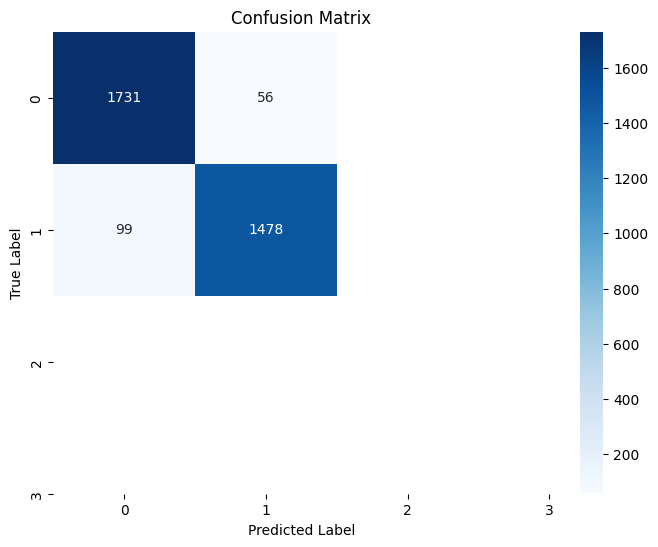

Accuracy: 95.39%
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      1787
         1.0       0.96      0.94      0.95      1577

    accuracy                           0.95      3364
   macro avg       0.95      0.95      0.95      3364
weighted avg       0.95      0.95      0.95      3364



In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

test_dataset = keras.utils.image_dataset_from_directory(
    "/content/Axial CT Imaging Dataset for AI-Powered Kidney Stone Detection A Resource for Deep Learning Research/Axial CT Imaging Dataset for AI-Powered Kidney Stone Detection A Resource for Deep Learning Research/Kindy Stone Dataset/Original Dataset",
    labels="inferred",
    label_mode='binary',
    color_mode='rgb',
    batch_size=64
)

def preprocess_test(image,label):
    # image = histogram_equalization(image)
    image = change_range(image)
    return image,label



test_dataset = test_dataset.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

predictions = []
real_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    preds = np.where(preds > 0.5, 1, 0)
    predictions.extend(preds)
    real_labels.extend(labels.numpy())


cm = confusion_matrix(real_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(real_labels, predictions)
print(f"Accuracy: {accuracy:.2%}")



print(classification_report(real_labels, predictions))